In [35]:
import torch
import numpy as np
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt

external_path=''

In [36]:
concepts=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [37]:
def boundary_pairs(positive_concept,negative_concept,layer):
    for k in range(1,11):
        if k==1:
            positive_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
            positive_concept_activations=torch.cat([positive_concept_activations,activations])
    
    for k in range(1,11):
        if k==1:
            negative_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
            negative_concept_activations=torch.cat([negative_concept_activations,activations])

    pairs_from_positive=[]
    negative_idxs=[]

    for k in range(positive_concept_activations.shape[0]):
        positive_latent=positive_concept_activations[k,:]
        distances=np.zeros(negative_concept_activations.shape[0])
        for l in range(negative_concept_activations.shape[0]):
            distances[l]=torch.norm(positive_latent-negative_concept_activations[l,:])
        pairs_from_positive.append([k,distances.argmin()])
        negative_idxs.append(distances.argmin())

    negative_idxs=list(set(negative_idxs))

    positive_idxs=[]
    pairs_from_negative=[]

    for k in range(negative_concept_activations.shape[0]):
        negative_latent=negative_concept_activations[k,:]
        distances=np.zeros(positive_concept_activations.shape[0])
        for l in range(positive_concept_activations.shape[0]):
            distances[l]=torch.norm(negative_latent-positive_concept_activations[l,:])
        pairs_from_negative.append([distances.argmin(),k])
        positive_idxs.append(distances.argmin())

    positive_idxs=list(set(positive_idxs))

    pairs=[]

    for pair in pairs_from_positive:
        if pair[0] in positive_idxs:
            pairs.append(pair)
        
    for pair in pairs_from_negative:
        if pair[1] in negative_idxs:
            if not(pair in pairs):
                pairs.append(pair)

    return pairs

In [85]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\pairs')):
        os.makedirs(f'{external_path}\\boundary_info\\{layer}\\pairs')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            if os.path.exists(f'{external_path}\\boundary_info\\{layer}\\pairs\\{negative_concept}_{positive_concept}.npy'):
                pairs_reversed=np.load(f'{external_path}\\boundary_info\\{layer}\\pairs\\{negative_concept}_{positive_concept}.npy')
                pairs=[[pair[1],pair[0]] for pair in pairs_reversed]
            else:
                pairs=boundary_pairs(positive_concept,negative_concept,layer)
            np.save(f'{external_path}\\boundary_info\\{layer}\\pairs\\{positive_concept}_{negative_concept}.npy',np.array(pairs))

Layer 0: truck_ship: 100%|██████████| 1/1 [59:22<00:00, 3562.22s/it]


In [39]:
def boundary_distances(positive_concept,negative_concept,layer):
    pairs=np.load(f'{external_path}\\boundary_info\\{layer}\\pairs\\{positive_concept}_{negative_concept}.npy')

    for k in range(1,11):
        if k==1:
            positive_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
            positive_concept_activations=torch.cat([positive_concept_activations,activations])
    
    for k in range(1,11):
        if k==1:
            negative_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
            negative_concept_activations=torch.cat([negative_concept_activations,activations])

    distances=np.zeros(len(pairs))
    for k,pair in enumerate(pairs):
        positive_digit_latent=positive_concept_activations[pair[0],:]
        negative_digit_latent=negative_concept_activations[pair[1],:]
        distances[k]=torch.norm(positive_digit_latent-negative_digit_latent).item()
        if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\distances')):
            os.makedirs(f'{external_path}\\boundary_info\\{layer}\\distances')
    np.save(f'{external_path}\\boundary_info\\{layer}\\distances\\{positive_concept}_{negative_concept}.npy',distances)

In [86]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\distances')):
        os.makedirs(f'{external_path}\\boundary_info\\{layer}\\distances')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            boundary_distances(positive_concept,negative_concept,layer)

Layer 0: truck_ship: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it] 


In [41]:
def boundary_normals(positive_concept,negative_concept,layer):
    pairs=np.load(f'{external_path}\\boundary_info\\{layer}\\pairs\\{positive_concept}_{negative_concept}.npy')

    for k in range(1,11):
        if k==1:
            positive_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{positive_concept}\\layer{layer}_{k}.pt').squeeze(1)
            positive_concept_activations=torch.cat([positive_concept_activations,activations])
    
    for k in range(1,11):
        if k==1:
            negative_concept_activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
        else:
            activations=torch.load(f'{external_path}\\concept_token_activations\\{negative_concept}\\layer{layer}_{k}.pt').squeeze(1)
            negative_concept_activations=torch.cat([negative_concept_activations,activations])

    for k,pair in enumerate(pairs):
        positive_digit_latent=positive_concept_activations[pair[0],:]
        negative_digit_latent=negative_concept_activations[pair[1],:]
        if k==0:
            normal_vector=positive_digit_latent-negative_digit_latent
            normal_vector/=torch.norm(normal_vector).item()
            normals=normal_vector.unsqueeze(0).detach().numpy()
        else:
            normal_vector=positive_digit_latent-negative_digit_latent
            normal_vector/=torch.norm(normal_vector).item()
            normals=np.concatenate([normals,normal_vector.unsqueeze(0).detach().numpy()])
    np.save(f'{external_path}\\boundary_info\\{layer}\\normals\\{positive_concept}_{negative_concept}.npy',normals)

In [87]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\normals')):
        os.makedirs(f'{external_path}\\boundary_info\\{layer}\\normals')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            boundary_normals(positive_concept,negative_concept,layer)

Layer 0: truck_ship: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it] 


In [34]:
def boundary_dots_cav(positive_concept,negative_concept,layer):
    normals=np.load(f'{external_path}\\boundary_info\\{layer}\\normals\\{positive_concept}_{negative_concept}.npy')
    cav=torch.load(f'{external_path}\\concept_activation_vectors\\{layer}\\{positive_concept}_{negative_concept}.pt')
    dots=np.zeros(len(normals))
    for k,normal in enumerate(normals):
        dots[k]=torch.dot(torch.tensor(normal),cav)
    np.save(f'{external_path}\\boundary_info\\{layer}\\dots_cav\\{positive_concept}_{negative_concept}.npy',dots)

def boundary_dots_cbv(positive_concept,negative_concept,layer):
    normals=np.load(f'{external_path}\\boundary_info\\{layer}\\normals\\{positive_concept}_{negative_concept}.npy')
    cbv=torch.load(f'{external_path}\\concept_boundary_vectors\\{layer}\\{positive_concept}_{negative_concept}.pt')
    dots=np.zeros(len(normals))
    for k,normal in enumerate(normals):
        dots[k]=torch.dot(torch.tensor(normal),cbv)
    np.save(f'{external_path}\\boundary_info\\{layer}\\dots_cbv\\{positive_concept}_{negative_concept}.npy',dots)

In [88]:
pbar=tqdm(range(13))
for layer in pbar:
    if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\dots_cav')):
        os.makedirs(f'{external_path}\\boundary_info\\{layer}\\dots_cav')
    if not(os.path.exists(f'{external_path}\\boundary_info\\{layer}\\dots_cbv')):
        os.makedirs(f'{external_path}\\boundary_info\\{layer}\\dots_cbv')
    for positive_concept in concepts:
        for negative_concept in concepts:
            if positive_concept==negative_concept:
                continue
            pbar.set_description(f'Layer {layer}: {positive_concept}_{negative_concept}')
            boundary_dots_cav(positive_concept,negative_concept,layer)
            boundary_dots_cbv(positive_concept,negative_concept,layer)

Layer 12: truck_ship: 100%|██████████| 2/2 [00:07<00:00,  3.53s/it]         


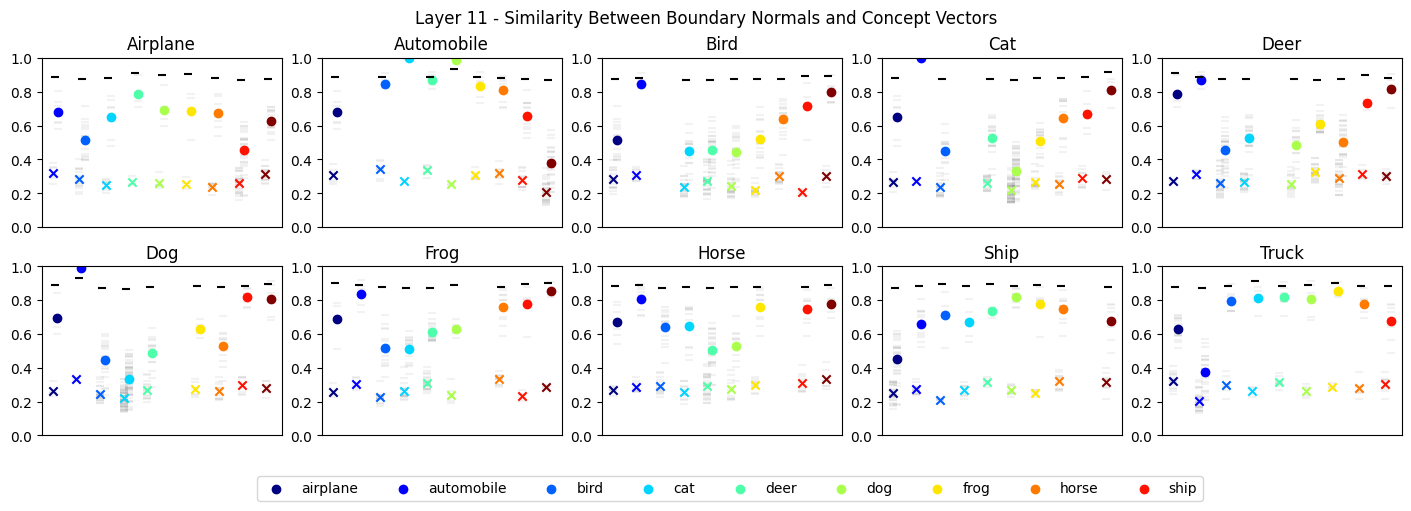

: 

In [90]:
layer=11
fig,axs=plt.subplots(nrows=2,ncols=5,layout='constrained')
fig.suptitle(f'Layer {layer} - Similarity Between Boundary Normals and Concept Vectors')
fig.set_figwidth(14)
fig.set_figheight(5)
colors = plt.cm.jet(np.linspace(0,1,10))
for n,ax in enumerate(axs.flatten()):
    positive_concept=concepts[n]
    c_num=0
    ax.set_title(f'{positive_concept[0].upper()}{positive_concept[1:]}')
    min_y=0
    for negative_concept in concepts:
        if negative_concept==positive_concept:
            c_num+=1
            continue

        dots_cav=np.load(f'{external_path}\\boundary_info\\{layer}\\dots_cav\\{positive_concept}_{negative_concept}.npy')
        dots_cbv=np.load(f'{external_path}\\boundary_info\\{layer}\\dots_cbv\\{positive_concept}_{negative_concept}.npy')
        dots_random=np.load(f'{external_path}\\concept_boundary_vectors_from_random\\{layer}\\{positive_concept}_{negative_concept}\\dots.npy')

        ax.scatter(x=np.ones(len(dots_cav))*(c_num-0.1),y=dots_cav,marker='_',alpha=0.1,color='grey')
        ax.scatter(x=np.ones(len(dots_cbv))*(c_num+0.1),y=dots_cbv,marker='_',alpha=0.1,color='grey')
        min_y=min(min_y,np.mean(dots_cav))
        ax.scatter(c_num-0.1,np.mean(dots_cav),marker='x',color=colors[c_num])
        ax.scatter(c_num+0.1,np.mean(dots_cbv),marker='o',color=colors[c_num],label=negative_concept)
        min_y=min(min_y,np.mean(dots_cbv))

        ax.scatter(c_num,np.mean(dots_random),marker='_',color='black')
        c_num+=1
        ax.tick_params(axis='x',which='both',bottom=False,labelbottom=False)
    ax.set_ylim((min_y,1))
ax.legend(bbox_to_anchor=(-3.8,-0.3,4,0.102),ncols=10,mode='expand')
plt.show()